In [1]:
sys.path.insert(1, os.path.abspath('/Users/jonasvvr/Documents/KULeuven/thesis/Soccer-EPV-Framework/LaurieOnTracking/'))

In [2]:
import data_handler as dh
import visualization as viz
import pandas as pd

In [3]:
DATA_DIR_single = '../bru_data/data/comp-4zwgbb66rif2spcoeeol2motx/tmcl-1qtpbdbeudho5i7fu5z2lp2j8/fx-4sekj9hgwxzq3y4ih9415239w'
DATA_DIR = '../bru_data/data/comp-4zwgbb66rif2spcoeeol2motx/tmcl-1qtpbdbeudho5i7fu5z2lp2j8'

event_data_single = dh.read_event_data(DATA_DIR_single)
# event_data = dh.read_dir_event_data(DATA_DIR)

In [4]:
event_data_single.shape

(1749, 11)

(<Figure size 1200x800 with 1 Axes>, <AxesSubplot: >)

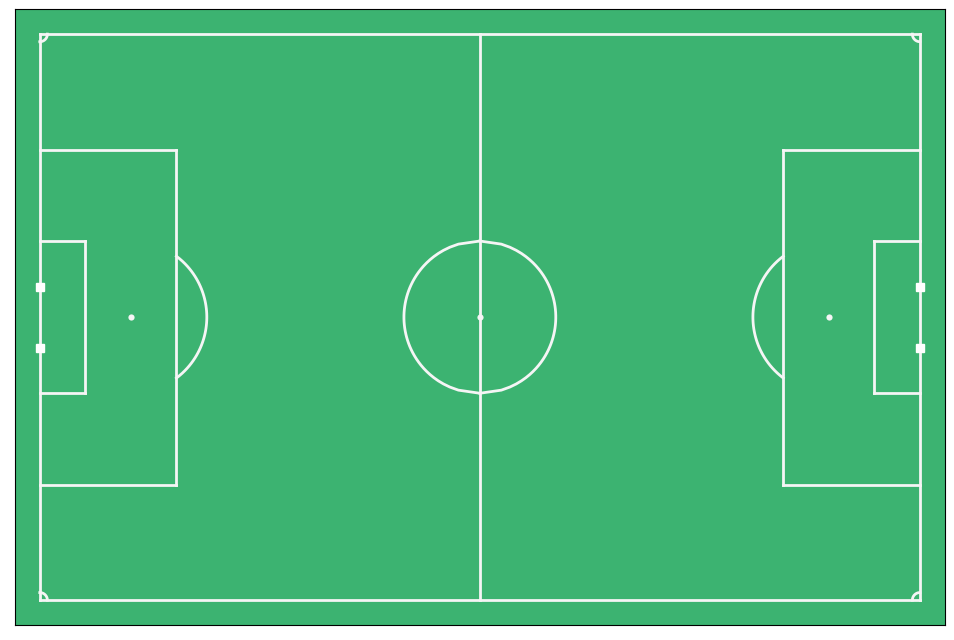

In [5]:
viz.plot_events(event_data_single.loc[10000:10020])

In [6]:
tracking_single = dh.read_tracking_data_single(DATA_DIR_single)

In [7]:
tracking_single

,Framecount,Match period,Match status,Column 5,Ball xyz
0,0,1,0,"[[0, 13d7ao0j091449ia61cuut87p, 26, 52.564, 31...","[52.4, 32.93, 0]"
1,40,1,0,"[[0, 13d7ao0j091449ia61cuut87p, 26, 52.554, 31...","[52.42, 32.82, 0]"
2,80,1,0,"[[0, 13d7ao0j091449ia61cuut87p, 26, 52.544, 31...","[52.44, 32.72, 0]"
3,120,1,0,"[[0, 13d7ao0j091449ia61cuut87p, 26, 52.533, 31...","[52.46, 32.61, 0]"
4,160,1,0,"[[0, 13d7ao0j091449ia61cuut87p, 26, 52.523, 31...","[52.48, 32.51, 0]"
...,...,...,...,...,...
140677,2917880,2,0,"[[0, 13d7ao0j091449ia61cuut87p, 26, 27.65, 41....","[8.82, 58.07, 0]"
140678,2917920,2,0,"[[0, 13d7ao0j091449ia61cuut87p, 26, 27.531, 41...","[8.65, 58.02, 0]"
140679,2917960,2,0,"[[0, 13d7ao0j091449ia61cuut87p, 26, 27.412, 41...","[8.49, 57.97, 0]"
140680,2918000,2,0,"[[0, 13d7ao0j091449ia61cuut87p, 26, 27.293, 41...","[8.26, 57.78, 0]"


(<Figure size 1200x800 with 1 Axes>, <AxesSubplot: >)

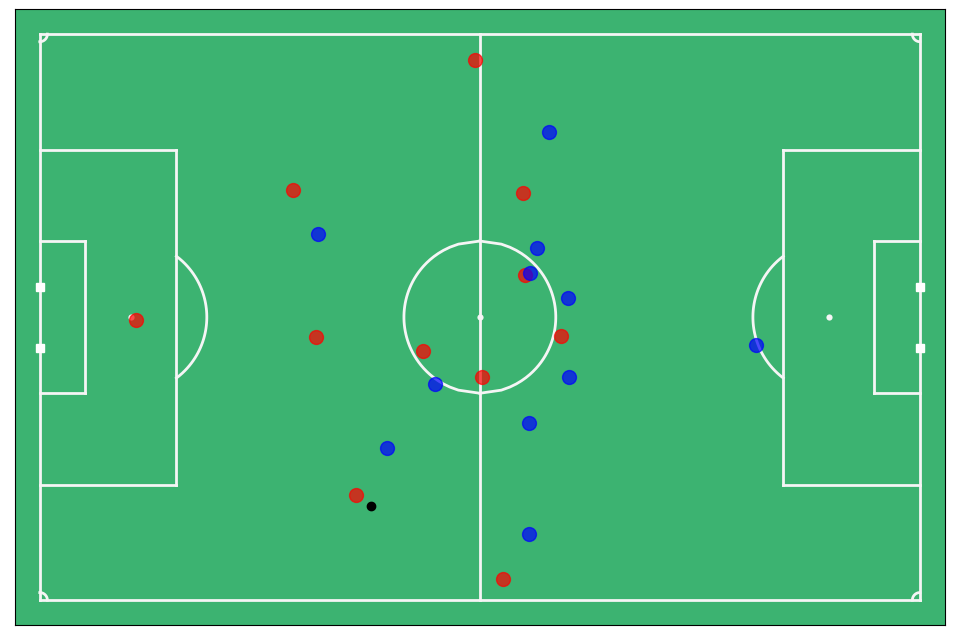

In [8]:
viz.plot_frame(tracking_single.iloc[100000])